# Fig 1 - resistance in terms of mean and variance

## Overview:

N sprays most important thing for resistance

Effect of changes to initial distributions - variance and mean

(maths in appendix proves it)

And resistance increases with dose

Then can say simple things about resistance management, but yield and econ more complex (figs 2 onwards address)

FIG:
1. Mean of dist vs severity in diff cases (doses / sprays)
2. Mean of dist vs n sprays/dose
3. Variance vs change in following year or vs mean in year X

## Required data:

Uses `local/fig1_data.py`.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [2]:
import pandas as pd
from scipy.stats import norm
from scipy import signal

import seaborn as sns
from math import floor

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import copy

from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
)

from poly2.utils import get_dist_mean, edge_values

from poly2.run import simulations_run, no_joblib_simulations_run
from poly2.config import Config

In [3]:
COLZ = sns.color_palette('muted').as_hex()

# Plot

In [148]:
df_in = (
    pd.read_csv('../outputs/combined/fig1_500_50.csv')
    .assign(total_sprays = lambda df: df.sprays * df.year)
    .sort_values(['sprays', 'dose', 'year'])
)

df_in.head()

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/combined/fig1_500_50.csv'

In [160]:
df_in = (
    pd.read_csv('../outputs/combined/fig1_zero.csv')
    .assign(total_sprays = lambda df: df.sprays * df.year)
)

df_in.head()

,sprays,dose,year,sev,fung_mean,fung_var,total_sprays
0,1,0.5,0,NaN,0.002553,0.000056,0
1,1,0.5,1,5.301001,0.003466,0.000111,1
2,1,0.5,2,5.401781,0.005042,0.000226,2
3,1,0.5,3,5.553837,0.007790,0.000460,3
4,1,0.5,4,5.785162,0.012546,0.000921,4


In [186]:
df_use = (
    df_in
    .join(
    (
        df_in
        .groupby(['sprays', 'dose'])
        .diff()
        .loc[:, ['fung_mean']]
        .shift(-1)
        .rename(columns = {'fung_mean': 'mean_diff'})
    )
    )
)

df_use.head(18)

,sprays,dose,year,sev,fung_mean,fung_var,total_sprays,mean_diff
0,1,0.5,0,NaN,0.002553,0.000056,0,0.000913
1,1,0.5,1,5.301001,0.003466,0.000111,1,0.001576
2,1,0.5,2,5.401781,0.005042,0.000226,2,0.002748
3,1,0.5,3,5.553837,0.007790,0.000460,3,0.004756
4,1,0.5,4,5.785162,0.012546,0.000921,4,0.007956
5,1,0.5,5,6.132032,0.020502,0.001770,5,0.012459
6,1,0.5,6,6.632180,0.032961,0.003160,6,0.017729
7,1,0.5,7,7.304353,0.050689,0.005118,7,0.022565
8,1,0.5,8,8.119972,0.073254,0.007452,8,0.025871
9,1,0.5,9,9.000344,0.099125,0.009852,9,0.027427


## Fig fn

In [192]:
def fig1(df):
    
    fig = make_subplots(
        rows=3,
        cols=1,
        # shared_xaxes=True,
        # horizontal_spacing=0.33,
        vertical_spacing=0.15,
    )
    
    # len 10
    # colors1 = px.colors.sequential.Viridis
    # colors2 = px.colors.sequential.Agsunset
    # colors3 = px.colors.sequential.Cividis
    
    # cols = {1: colors1, 2: colors2, 3: colors3}
    
    cols = ['red', 'blue', 'black']
    dashes = ['dot', 'solid']
    
    for spray, color in zip([1,2,3], cols):
        by_spray = df.loc[df.sprays==spray]
        
        for dose, dash in zip(by_spray.dose.unique(), dashes):
            
            by_spray_and_dose = by_spray.loc[lambda dd: dd.dose==dose]
            
            name_this_dose = f'Dose={dose:.1f}, spray={spray}'
            
            t_1 = go.Scatter(
                    x=by_spray_and_dose.fung_mean,
                    y=by_spray_and_dose.sev,
                    mode='lines+markers',
                    name=name_this_dose,
                    marker=dict(color=color, size=4),
                    line=dict(color=color, dash=dash),
                )

            fig.add_trace(t_1, row=1, col=1)
            
            
            
            t_2 = go.Scatter(
                x=by_spray_and_dose.total_sprays,
                y=by_spray_and_dose.fung_mean,
                mode='lines+markers',
                name=name_this_dose,
                marker=dict(color=color, size=4),
                line=dict(color=color, dash=dash),
                opacity=0.5,
                showlegend=False
            )
    
            fig.add_trace(t_2, row=2, col=1)
        
            t_3 = go.Scatter(
                x=by_spray_and_dose.fung_var,
                y=by_spray_and_dose.mean_diff,
                mode='lines+markers',
                name=name_this_dose,
                marker=dict(color=color, size=4),
                line=dict(color=color, dash=dash),
                opacity=0.5,
                showlegend=False
            )
    
            fig.add_trace(t_3, row=3, col=1)
            
            
    
    
    
    
    
    fig.update_layout(standard_layout(True, height=800))
    
    fig.update_layout(legend=dict(x=0, y=1.18, orientation='h', font=dict(size=12)))
    
    corners = corner_annotations_colwise(
        3, 1,
        1.05, 0,
        0.38, 0
    )
    
    fig.update_layout(annotations=corners)
    
    # X axis    
    
    # xrange = [0,15]
    
    fig.update_xaxes(title_text='Trait mean',
                     row=1, col=1,
                     range=[-0.01, 1.01],
                     showgrid=False)
    
    fig.update_xaxes(title_text='Number of applications',
                     row=2, col=1,
                     # range=xrange,
                     showgrid=False)
    
    fig.update_xaxes(title_text='Trait variance',
                     row=3, col=1,
                     # range=xrange,
                     showgrid=False)
    
    
    # Y axis    
    fig.update_yaxes(title_text='Disease severity',
                     row=1, col=1,
                     showgrid=False)
    
    fig.update_yaxes(title_text='Trait mean',
                         row=2, col=1,
                         type='log',
                         showgrid=False)
    
    fig.update_yaxes(title_text='Change in trait mean',
                         row=3, col=1,
                         showgrid=False)

    return fig

## FIG

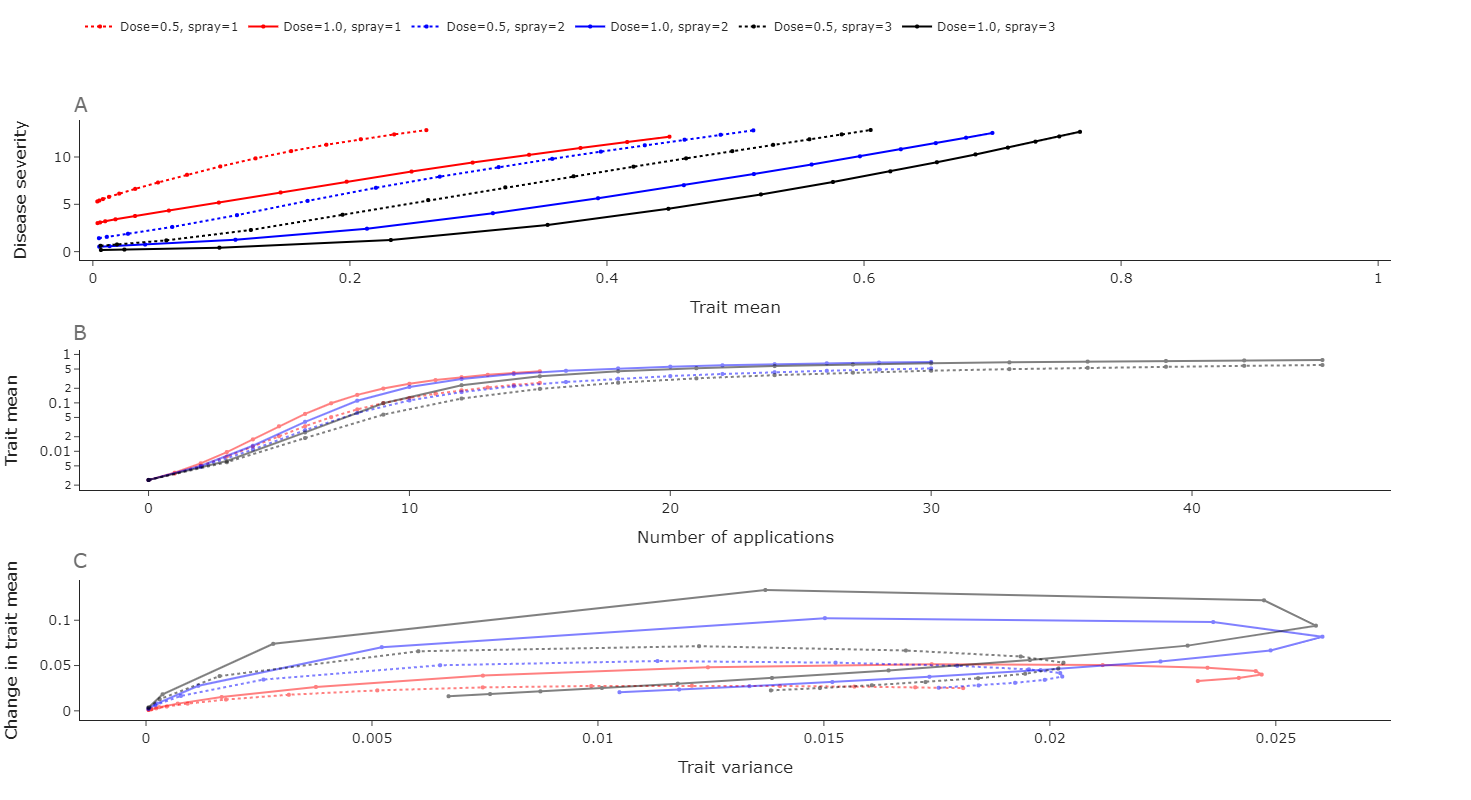

In [193]:
f = fig1(df_use)

f.show()

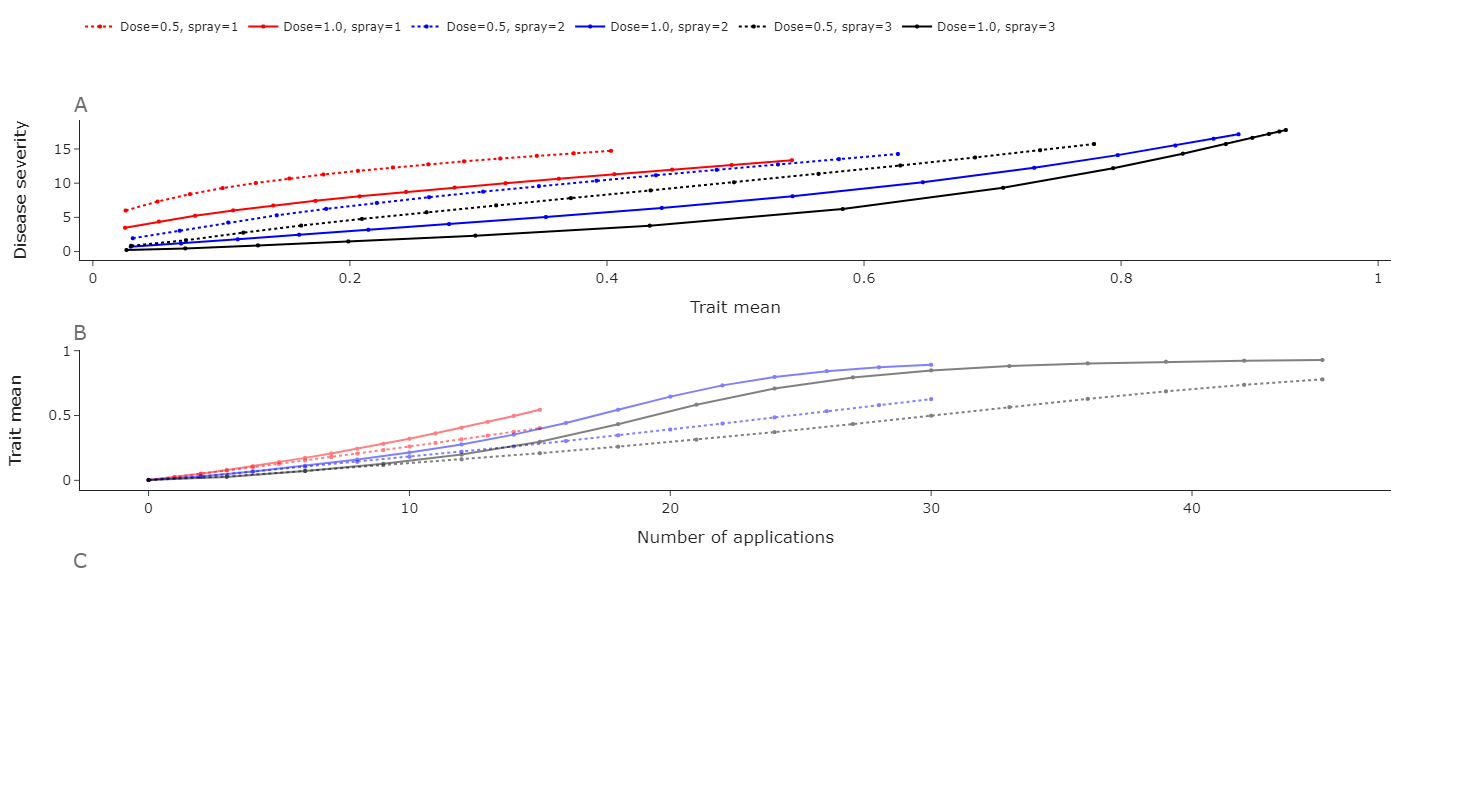

In [150]:
f = fig1(df_in)

f.show()

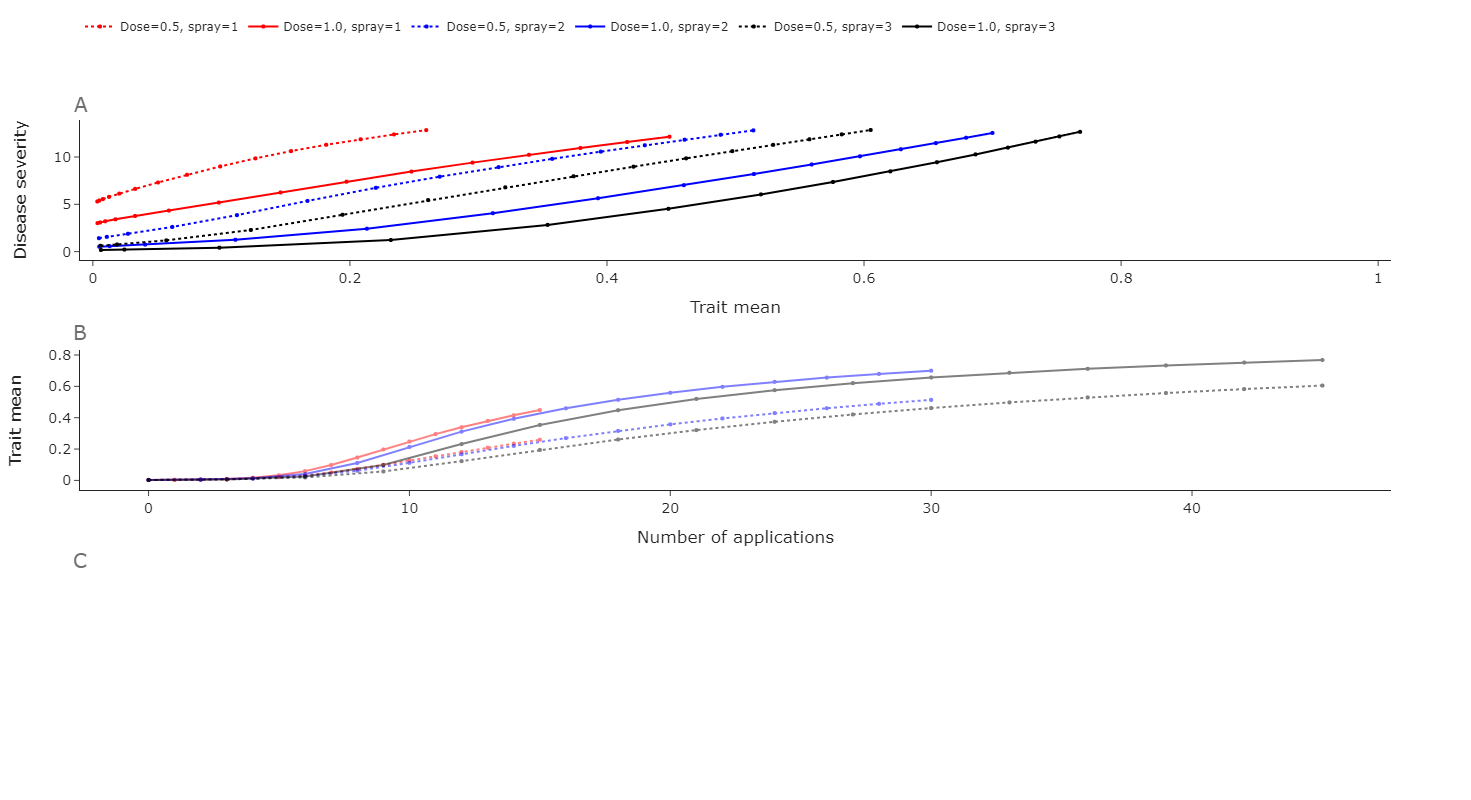

In [134]:
f = fig1(df_use)

f.show()

More applications gives slightly slower relative increase:

- perhaps due to mutation having less of an effect? i.e. fewer generations so less mutation?
- something to do with chemical decay / density dependence?

High dose / N applications:

- reduced mutation
- increased selection on existing variation or variants that do arise via mutation (but not per spray increased?)

In [11]:
f.write_image('../figures/paper/fig1.png')